## 画像分類モデル

・ニューラルネットの構築
・Dataset,DataLoaderの読み込み
・分類タスクの損失

In [1]:
from torchvision import datasets

from matplotlib import pyplot as plt
import numpy as np
import torch

In [37]:
data_path = "../data/p1ch7/"
#引数は保存のパス、訓練用かテスト用か、pytorchで保存して良いか
#他にもSVHN ,COCO,Ominglotなどがある
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [54]:
#torch.util.data.datasetsのサブクラスとして返される
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

##datasetクラス

In [38]:
len(cifar10), len(cifar10_val)

(50000, 10000)

datasetはデータを保持している訳ではなく、__len__,__getitem__を介してデータへのアクセスを提供する

In [39]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [40]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

<function matplotlib.pyplot.show(close=None, block=None)>

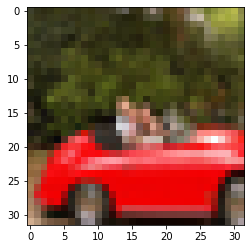

In [35]:
plt.imshow(img)
plt.show

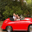

In [44]:
img

画像の変換はtorchvisionのtransforms

In [9]:
from torchvision import transforms
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [10]:
img_arr = np.array(img)
print(img_arr.shape)

(32, 32, 3)


In [11]:
#To.tensorではpil画像からテンソルへ変換できる
#一度インスタンス化してから引数に画像を入れる


from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)

print(f"変換後{img_t.shape}")

変換後torch.Size([3, 32, 32])


In [12]:
#datasetへの引数にもtransformsで渡せる
tensor_cifar10 = tensor_cifar10 = datasets.CIFAR10(data_path,
                                                  train=True,
                                                  download=False,
                                                  transform = transforms.ToTensor())

In [13]:
#pilではなくtensor
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [14]:
#0から１.0へのスケーリングもされる
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

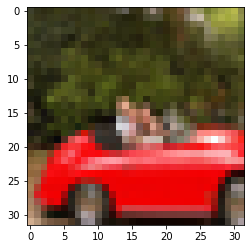

In [15]:
#img_tが元の画像なのか確認

plt.imshow(img_t.permute(1,2,0))
plt.show()

## データの正規化

In [19]:
tensor_cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/p1ch7/
    Split: Train
    StandardTransform
Transform: ToTensor()

transform.Composeを用いて複数の変換を繋げて行うことが可能。
正規化やデータ拡張がある
平均0、標準偏差1の正規化を行うことは良い習慣である

正規化を行う理由は
・データを一定の範囲に保ち、その範囲内（0＋ー1）で線形である活性化関数を選択すつことで、ニューロンが非0の可能性を上げる（訓練が速くなる）
・各チャネルを正規化することで、同じ学習率の使用ができる

平均値と標準偏差をあらかじめ計算しなければいけないがこの計算を、transform.Normalizeが行う


In [25]:
#viewの確認
points=torch.zeros(3,32,32,100)
points.shape

#全ての画像の平均をチャネルごとに行う
points.view(3,-1).shape, points.view(3, -1).mean(dim=1).shape

(torch.Size([3, 102400]), torch.Size([3]))

In [16]:
#CIFAR10がデータが小さく、メモリ内で処理する
#下記で全ての画像をまとめたテンソルを作り、
#imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
#imgs.view(3, -1).mean(dim=1)  # <1>
#imgs.view(3, -1).std(dim=1)

In [17]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [27]:
#ToTensorと合わせてtransformを作r,datasetsに組み込む

transformed_cifar10 = datasets.CIFAR10(
            data_path, train=True, download=False, 
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                     (0.1470, 0.2435, 0.2626))
            ]))

In [46]:
img_t, _ = transformed_cifar10[99]
img_t.shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


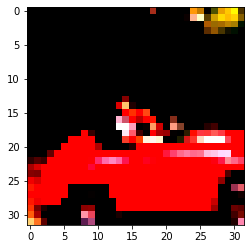

In [50]:
#RGBレベルが変化している。データとしては存在しておりmatplotlibが黒く表示している
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

##　画像分類モデル作成

飛行機と鳥の判別モデルを作る
ラベル「0」： airplane（飛行機）
ラベル「1」： automobile（自動車）
ラベル「2」： bird（鳥）
ラベル「3」： cat（猫）
ラベル「4」： deer（鹿）
ラベル「5」： dog（犬）
ラベル「6」： frog（カエル）
ラベル「7」： horse（馬）
ラベル「8」： ship（船）
ラベル「9」： truck（トラック）

In [2]:
from torchvision import datasets
from torchvision import transforms
import torch

data_path = "../data/p1ch7/"

In [3]:
cifar10 = datasets.CIFAR10(
            data_path, train=True, download=False, 
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                     (0.1470, 0.2435, 0.2626))
            ]))

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
len(cifar10),len(cifar10_val)

(50000, 10000)

In [6]:
#cifar10の中から飛行機と鳥のみのdatasetsにする

label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

In [7]:
#データセットはdatasetsのサブクラスでなくても、getitemとlenメソッドが定義されていれば利用できる
type(cifar2[1]), type(cifar2)

(tuple, list)

## 全結合のモデルを試す

In [8]:
img,label = cifar2[1]
img_t = img.view(1,-1)
img_t.shape

torch.Size([1, 3072])

In [9]:
import torch.nn as nn
n_out = 2
#非線形を必ず挟む
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, n_out)
        )

今回は分類問題である。
ネットワーク上では１.0か０.０に対応させる。出力は鳥か飛行機二つのラベルであるため、ワンホットエンコーディングの表現に切り替える

CIFAR10の10カテゴリでも同様に可能であり、その時は長さが10のベクトルになる


モデルの出力の理想は飛行機はtorch.tensor([1.0、 0.0]),鳥の場合はtorch.tensor([0.0, 1.0])である。

実際にはその間の値が出力されることが予想される。
この値は0から1なので確率として解釈できる（出力の一番目が飛行機の確率、二番目が鳥の確率）

問題は出力の各値が0から1であること、二つの合計が1であること

この問題の解決策がsoftmax

## ソフトマックスを試す

In [10]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [11]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [12]:
softmax(x).sum()

tensor(1.)

In [13]:
#softmaxは単調関数で入力が低くなれば出力も低くなる
#しかし、比率は変化するためスケーリングは異なる

In [14]:
#バッチが存在するため、nnではインスタンス作成時に次元の指定が必要
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])
softmax(x)


tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [15]:
n_out = 2

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, n_out),
            nn.Softmax(dim=1)
        )
model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


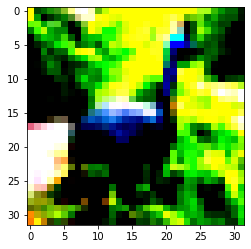

In [16]:
#入力の確認
img,_ =cifar2[0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [17]:
#画像を一つの次元に直し、バッチ次元を追加
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [18]:
#出力の確認
#重みとバイアスはランダムな値
out = model(img_batch)
out,out.shape

(tensor([[0.5079, 0.4921]], grad_fn=<SoftmaxBackward0>), torch.Size([1, 2]))

In [19]:
#バッチではなく、確率ベクトルの次元の最大値を取得したいからdim=1
value, index = torch.max(out, dim=1)
value, index

(tensor([0.5079], grad_fn=<MaxBackward0>), tensor([0]))

## 分類問題の損失関数

最大化するのは正しいクラスである確率out[class_index]である
outはsoftmaxの出力、class_indexは鳥か飛行機かの0、1のベクトル

この正しいクラスである確率は尤度と呼ばれ、尤度を最大化するため尤度が低い時に損失が大きいような損失関数が必要である
尤度が低い時はもう一つのカテゴリが正解である確立が高い
（尤度とは二つの確立分布の重ね合わせ）


予測確立を1にすることを目標にするのではなく、最もらしい予測ができれば良い

そのために対数尤度（NLL)を損失関数として用いる
データに低い確立が割り当てられた場合は無限大に、確立が上がると緩やかに減少する
NLLは入力に確立を受け取るため、一つのクラスの尤度が上がると、他のクラスの正解率は減少していく

入力データの流れ

1 モデルの順伝播を実行し、最後の層から出力値を得る

2 softmaxを計算し、各確率を求める

3 正しいクラスに対応する確率のみを取得

4 対数を計算しマイナス記号を付与し損失に加算する

nn.NLLLoss関数が利用できる
これは対数確立を入力値として受け取る

https://qiita.com/y629/items/1369ab6e56b93d39e043

結論を述べると，torch.nn.LogSoftmax に続いて torch.nn.NLLLoss を適用するのと，
torch.nn.CrossEntropyLoss を適用するのは同じことです。

実際の利用時

訓練時に NLLLoss を利用する場合は，モデルの最後の全結合層の後に，LogSoftmax の層を入れておく必要があります．
訓練時に CrossEntropyLoss を利用する場合は，そのような追加の層を入れる必要はありません．

In [20]:
#nnNLLLossへ与えるためにsoftmaxをLogSoftmaxへ変更
model = nn.Sequential(
        nn.Linear(3072,512),
        nn.Tanh(),
        nn.Linear(512,2),
        nn.LogSoftmax(dim=1))

In [21]:
loss = nn.NLLLoss()

In [22]:
img, label = cifar2[0]
torch.tensor([label])

tensor([1])

In [23]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(1.1319, grad_fn=<NllLossBackward0>)

分類問題（確立を扱う）でMSEを用いると損失が非常に早く飽和し、勾配が0になってしまう。
そのためNLL（負の対数尤度、クロスエントロピー誤差、交差エントロピー誤差）を用いる。

## 分類器の学習

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim


model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 20

#1エポック内で画像10000枚は大変なので1枚ごとにバックプロパゲーションすることとした
for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: %d, Loss: %f" %(epoch, float(loss)))

Epoch: 0, Loss: 5.544024
Epoch: 1, Loss: 7.257884
Epoch: 2, Loss: 8.210531
Epoch: 3, Loss: 8.310430
Epoch: 4, Loss: 7.301338
Epoch: 5, Loss: 15.187206
Epoch: 6, Loss: 12.531138
Epoch: 7, Loss: 8.311193
Epoch: 8, Loss: 3.529665
Epoch: 9, Loss: 15.479809
Epoch: 10, Loss: 15.015351
Epoch: 11, Loss: 11.621490
Epoch: 12, Loss: 14.394477
Epoch: 13, Loss: 7.127346
Epoch: 14, Loss: 8.674850
Epoch: 15, Loss: 12.703704
Epoch: 16, Loss: 8.039080
Epoch: 17, Loss: 9.383343
Epoch: 18, Loss: 9.888266
Epoch: 19, Loss: 10.561154
